In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from glob import glob
from itertools import chain
from collections import Counter
from PIL import Image
from tqdm import tqdm
import time
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.models.resnet import resnet18
from torchvision.models.densenet import densenet121
from torchvision.models.mobilenetv2 import mobilenet_v2
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchsummary import summary

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [2]:
seed = 17167055
torch.manual_seed(seed)
np.random.seed(seed)

In [3]:
root = 'dataset'
dataset = [str(data) for data in list(chain(*[i.glob('*') for i in Path(root).glob('*')]))]
print(f'Total data: {len(dataset)}')

Total data: 4092


In [4]:
def img_loader(path):
    with open(path, 'rb') as f:
        return Image.open(f).resize((224, 224)).convert('RGB')

In [5]:
images = [img_loader(i) for i in dataset]
labels = [i.split('\\')[-2] for i in dataset]

assert len(images)==len(labels)
assert len(images)==len(dataset)

In [6]:
scaler = LabelEncoder()
labels = scaler.fit_transform(labels)

In [7]:
Counter(labels).most_common()

[(0, 2162), (1, 1930)]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, stratify=labels, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=seed)
print(f'Train: {len(X_train)}')
print(f'Validation: {len(X_val)}')
print(f'Test: {len(X_test)}')

Train: 2454
Validation: 819
Test: 819


In [9]:
class MaskDataset(Dataset):
    def __init__(self, X, y, transform):
        self.image = X
        self.label = y
        self.transform = transform
        
    def __getitem__(self, idx):
        img = self.image[idx]
        lbl = self.label[idx]
        if self.transform:
            img = self.transform(img)
        return img, lbl
    
    def __len__(self):
        return len(self.image)

In [10]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAutocontrast(),
    transforms.RandomAdjustSharpness(2),
    transforms.ToTensor(),
])

transform_valtest = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
])

In [11]:
trainset = MaskDataset(X_train, y_train, transform_train)
trainloader = DataLoader(trainset, batch_size=16, shuffle=True)

valset = MaskDataset(X_val, y_val, transform_valtest)
valloader = DataLoader(valset, batch_size=1, shuffle=False)

testset = MaskDataset(X_test, y_test, transform_valtest)
testloader = DataLoader(testset, batch_size=1, shuffle=False)

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [13]:
def count_parameters(net):
    return sum(p.numel() for p in net.parameters() if p.requires_grad)

In [14]:
def train(epoch, trainloader, net):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    pbar = tqdm(trainloader, desc='Training')
    for batch_idx, (x_train, y_train) in enumerate(pbar):
        x_train, y_train = x_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = net(x_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += y_train.size(0)
        correct += predicted.eq(y_train.data).cpu().sum()
        pbar.set_postfix({"epoch":(epoch), "loss":(train_loss/(batch_idx+1)), "acc":(100.*correct/total).item()})
    lr_.append(scheduler.get_last_lr())
    acc = 100.*correct/total
    loss = train_loss/(batch_idx+1)
    return acc, loss

In [15]:
def valid(epoch, loader, net):
    net.eval()
    val_loss = 0
    correct = 0
    total = 0
    pbar = tqdm(loader,desc='Validating')
    with torch.no_grad():
        for batch_idx, (x_val, y_val) in enumerate(pbar):
            x_val, y_val = x_val.to(device), y_val.to(device)
            outputs = net(x_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += y_val.size(0)
            correct += predicted.eq(y_val.data).cpu().sum()
            pbar.set_postfix({"epoch":(epoch), "loss":(val_loss/(batch_idx+1)), "acc":(100.*correct/total).item()})
    acc = 100.*correct/total
    loss = val_loss/(batch_idx+1)
    return acc, loss

In [16]:
plotTotal = list()

## ResNet18

In [17]:
net = resnet18(pretrained=True)
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 2, bias=True)
rnetsnet = net.to(device)
print(f'number of trainable params: {count_parameters(net)}')
print(net)

number of trainable params: 11177538
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-4)
n_epochs = 100
scheduler = CosineAnnealingLR(optimizer, n_epochs)

In [19]:
start = time.time()
best_acc = 0.0
train_acc_ = []
train_loss_ = []
valid_acc_ = []
valid_loss_ = []
epoch_ = []
lr_ = []
for epoch in range(n_epochs):
    train_acc, train_loss = train(epoch, trainloader, net)
    val_acc, val_loss = valid(epoch, valloader, net)
    train_acc_.append(train_acc)
    train_loss_.append(train_loss)
    valid_acc_.append(val_acc)
    valid_loss_.append(val_loss)
    scheduler.step()
    if (val_acc > best_acc):
        best_acc = val_acc
        print(f'Best acc: {best_acc:.4f}, saving...')
        torch.save(net, f'models/{datetime.now().strftime("%d%m%Y_%H%M%S")}_resnet18_{best_acc:.4f}_epoch_{epoch}.pth')
        epoch_.append(epoch)
end = time.time()
print(f'time taken: {(end-start):.4f}s')

Validating: 100%|██████████| 819/819 [00:06<00:00, 120.04it/s, epoch=0, loss=0.172, acc=93.5] 


Best acc: 93.5287, saving...


Validating: 100%|██████████| 819/819 [00:06<00:00, 118.85it/s, epoch=1, loss=0.102, acc=97.1] 


Best acc: 97.0696, saving...


Validating: 100%|██████████| 819/819 [00:06<00:00, 118.96it/s, epoch=4, loss=0.0795, acc=97.6]


Best acc: 97.5580, saving...


Validating: 100%|██████████| 819/819 [00:06<00:00, 120.77it/s, epoch=5, loss=0.0475, acc=98.7]


Best acc: 98.6569, saving...


Validating: 100%|██████████| 819/819 [00:06<00:00, 119.04it/s, epoch=19, loss=0.0371, acc=99]  


Best acc: 99.0232, saving...


Validating: 100%|██████████| 819/819 [00:06<00:00, 120.10it/s, epoch=26, loss=0.0306, acc=99.4]


Best acc: 99.3895, saving...


Validating: 100%|██████████| 819/819 [00:06<00:00, 121.54it/s, epoch=34, loss=0.016, acc=99.5] 


Best acc: 99.5116, saving...


Validating: 100%|██████████| 819/819 [00:06<00:00, 119.59it/s, epoch=51, loss=0.0143, acc=99.8] 


Best acc: 99.7558, saving...


Validating: 100%|██████████| 819/819 [00:06<00:00, 121.18it/s, epoch=64, loss=0.0122, acc=99.9]


Best acc: 99.8779, saving...


Validating: 100%|██████████| 819/819 [00:06<00:00, 126.01it/s, epoch=99, loss=0.0175, acc=99.5] 

time taken: 1813.2667s


In [20]:
print(f'train_acc: {train_acc:.2f}')
print(f'val_acc: {val_acc:.2f}')
model_path = f'models/{datetime.now().strftime("%d%m%Y_%H%M%S")}_resnet18_{train_acc:.2f}_{val_acc:.2f}_last.pth'
print(f'last model path: {model_path}')
torch.save(net, model_path)

train_acc: 98.70
val_acc: 99.51
last model path: models/08012022_002308_resnet18_98.70_99.51_last.pth


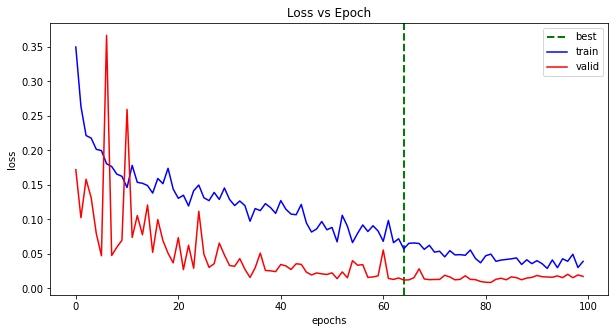

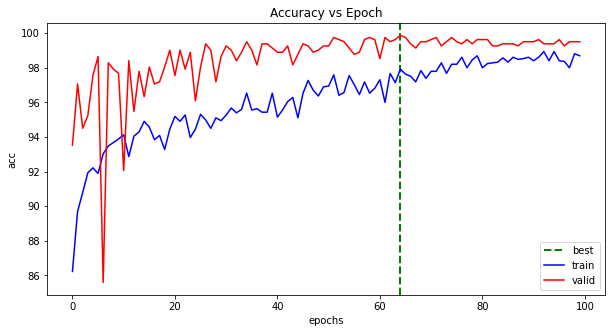

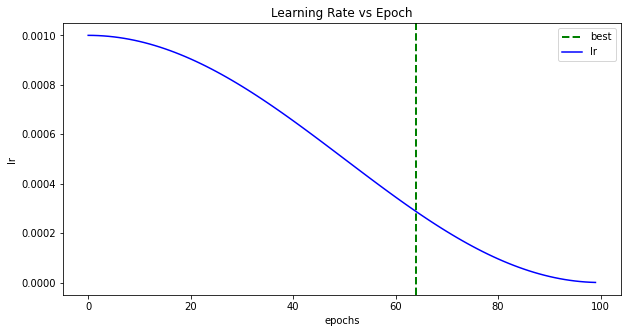

In [21]:
plt.figure(figsize=(10,5))
plt.axvline(epoch_[-1], 0, 1, c='g', ls='--', lw=2, label='best')
plt.plot(range(n_epochs), train_loss_, 'b', label='train')
plt.plot(range(n_epochs), valid_loss_, 'r', label='valid')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.axvline(epoch_[-1], 0, 1, c='g', ls='--', lw=2, label='best')
plt.plot(range(n_epochs), train_acc_, 'b', label='train')
plt.plot(range(n_epochs), valid_acc_, 'r', label='valid')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.axvline(epoch_[-1], 0, 1, c='g', ls='--', lw=2, label='best')
plt.plot(range(n_epochs), lr_, 'b', label='lr')
plt.xlabel('epochs')
plt.ylabel('lr')
plt.title('Learning Rate vs Epoch')
plt.legend()
plt.show()

In [22]:
plotTotal.append([net, train_acc_, train_loss_])

## Mobilenet_v2

In [23]:
net = mobilenet_v2(pretrained=True)
num_ftrs = net.classifier[1].in_features
net.classifier[1] = nn.Linear(num_ftrs, 2, bias=True)
net = net.to(device)
print(f'number of trainable params: {count_parameters(net)}')
print(net)

number of trainable params: 2226434
MobileNetV2(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
     

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-4)
n_epochs = 100
scheduler = CosineAnnealingLR(optimizer, n_epochs)

In [25]:
start = time.time()
best_acc = 0.0
train_acc_ = []
train_loss_ = []
valid_acc_ = []
valid_loss_ = []
epoch_ = []
lr_ = []
for epoch in range(n_epochs):
    train_acc, train_loss = train(epoch, trainloader, net)
    val_acc, val_loss = valid(epoch, valloader, net)
    train_acc_.append(train_acc)
    train_loss_.append(train_loss)
    valid_acc_.append(val_acc)
    valid_loss_.append(val_loss)
    scheduler.step()
    if (val_acc > best_acc):
        best_acc = val_acc
        print(f'Best acc: {best_acc:.4f}, saving...')
        torch.save(net, f'models/{datetime.now().strftime("%d%m%Y_%H%M%S")}_mobilenetv2_{best_acc:.4f}_epoch_{epoch}.pth')
        epoch_.append(epoch)
end = time.time()
print(f'time taken: {(end-start):.4f}s')

Validating: 100%|██████████| 819/819 [00:09<00:00, 82.52it/s, epoch=0, loss=0.0915, acc=97.6]


Best acc: 97.5580, saving...


Validating: 100%|██████████| 819/819 [00:09<00:00, 82.60it/s, epoch=2, loss=0.0533, acc=97.8]


Best acc: 97.8022, saving...


Validating: 100%|██████████| 819/819 [00:09<00:00, 82.82it/s, epoch=3, loss=0.0526, acc=98.7]


Best acc: 98.6569, saving...


Validating: 100%|██████████| 819/819 [00:09<00:00, 81.91it/s, epoch=8, loss=0.0394, acc=98.9]


Best acc: 98.9011, saving...


Validating: 100%|██████████| 819/819 [00:10<00:00, 80.37it/s, epoch=17, loss=0.0257, acc=99.4]


Best acc: 99.3895, saving...


Validating: 100%|██████████| 819/819 [00:10<00:00, 80.19it/s, epoch=27, loss=0.0182, acc=99.5]


Best acc: 99.5116, saving...


Validating: 100%|██████████| 819/819 [00:10<00:00, 81.34it/s, epoch=35, loss=0.0133, acc=99.6]


Best acc: 99.6337, saving...


Validating: 100%|██████████| 819/819 [00:10<00:00, 80.91it/s, epoch=39, loss=0.023, acc=99.8] 


Best acc: 99.7558, saving...


Validating: 100%|██████████| 819/819 [00:10<00:00, 81.05it/s, epoch=48, loss=0.0133, acc=99.9]


Best acc: 99.8779, saving...


Validating: 100%|██████████| 819/819 [00:10<00:00, 81.84it/s, epoch=99, loss=0.012, acc=99.9] 

time taken: 2484.7482s


In [26]:
print(f'train_acc: {train_acc:.2f}')
print(f'val_acc: {val_acc:.2f}')
model_path = f'models/{datetime.now().strftime("%d%m%Y_%H%M%S")}_mobilenetv2_{train_acc:.2f}_{val_acc:.2f}_last.pth'
print(f'last model path: {model_path}')
torch.save(net, model_path)

train_acc: 99.02
val_acc: 99.88
last model path: models/08012022_010637_mobilenetv2_99.02_99.88_last.pth


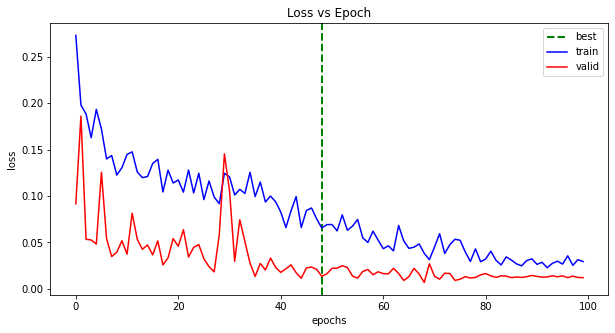

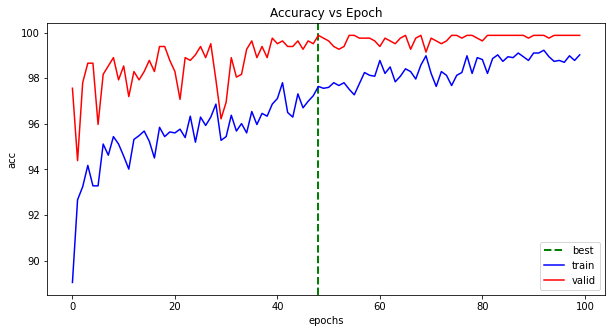

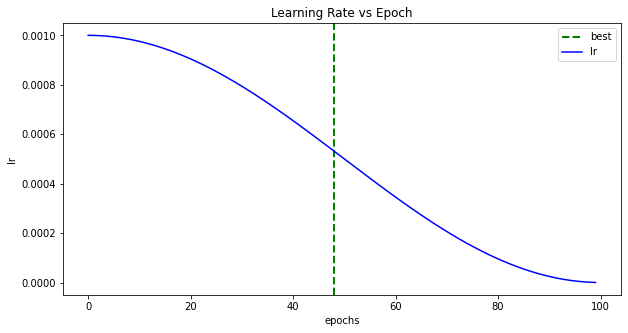

In [27]:
plt.figure(figsize=(10,5))
plt.axvline(epoch_[-1], 0, 1, c='g', ls='--', lw=2, label='best')
plt.plot(range(n_epochs), train_loss_, 'b', label='train')
plt.plot(range(n_epochs), valid_loss_, 'r', label='valid')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.axvline(epoch_[-1], 0, 1, c='g', ls='--', lw=2, label='best')
plt.plot(range(n_epochs), train_acc_, 'b', label='train')
plt.plot(range(n_epochs), valid_acc_, 'r', label='valid')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.axvline(epoch_[-1], 0, 1, c='g', ls='--', lw=2, label='best')
plt.plot(range(n_epochs), lr_, 'b', label='lr')
plt.xlabel('epochs')
plt.ylabel('lr')
plt.title('Learning Rate vs Epoch')
plt.legend()
plt.show()

In [28]:
plotTotal.append([net, train_acc_, train_loss_])

## Densenet121

In [29]:
net = densenet121(pretrained=True)
num_ftrs = net.classifier.in_features
net.classifier = nn.Linear(num_ftrs, 2, bias=True)
net = net.to(device)
print(f'number of trainable params: {count_parameters(net)}')
print(net)

number of trainable params: 6955906
DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, tra

In [30]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-4)
n_epochs = 100
scheduler = CosineAnnealingLR(optimizer, n_epochs)

In [31]:
start = time.time()
best_acc = 0.0
train_acc_ = []
train_loss_ = []
valid_acc_ = []
valid_loss_ = []
epoch_ = []
lr_ = []
for epoch in range(n_epochs):
    train_acc, train_loss = train(epoch, trainloader, net)
    val_acc, val_loss = valid(epoch, valloader, net)
    train_acc_.append(train_acc)
    train_loss_.append(train_loss)
    valid_acc_.append(val_acc)
    valid_loss_.append(val_loss)
    scheduler.step()
    if (val_acc > best_acc):
        best_acc = val_acc
        print(f'Best acc: {best_acc:.4f}, saving...')
        torch.save(net, f'models/{datetime.now().strftime("%d%m%Y_%H%M%S")}_densenet121_{best_acc:.4f}_epoch_{epoch}.pth')
        epoch_.append(epoch)
end = time.time()
print(f'time taken: {(end-start):.4f}s')

Validating: 100%|██████████| 819/819 [00:29<00:00, 27.42it/s, epoch=0, loss=0.257, acc=89.5]


Best acc: 89.4994, saving...


Validating: 100%|██████████| 819/819 [00:29<00:00, 27.52it/s, epoch=2, loss=0.115, acc=95.2] 


Best acc: 95.2381, saving...


Validating: 100%|██████████| 819/819 [00:29<00:00, 27.54it/s, epoch=3, loss=0.128, acc=96.1]


Best acc: 96.0928, saving...


Validating: 100%|██████████| 819/819 [00:29<00:00, 27.40it/s, epoch=4, loss=0.0824, acc=97.7]


Best acc: 97.6801, saving...


Validating: 100%|██████████| 819/819 [00:29<00:00, 27.34it/s, epoch=8, loss=0.0668, acc=97.8]


Best acc: 97.8022, saving...


Validating: 100%|██████████| 819/819 [00:29<00:00, 27.36it/s, epoch=9, loss=0.0595, acc=97.9]


Best acc: 97.9243, saving...


Validating: 100%|██████████| 819/819 [00:30<00:00, 27.23it/s, epoch=10, loss=0.0647, acc=98.7]


Best acc: 98.6569, saving...


Validating: 100%|██████████| 819/819 [00:29<00:00, 27.35it/s, epoch=27, loss=0.0373, acc=99.1]


Best acc: 99.1453, saving...


Validating: 100%|██████████| 819/819 [00:29<00:00, 27.50it/s, epoch=39, loss=0.0326, acc=99.4]


Best acc: 99.3895, saving...


Validating: 100%|██████████| 819/819 [00:29<00:00, 27.31it/s, epoch=49, loss=0.024, acc=99.5] 


Best acc: 99.5116, saving...


Validating: 100%|██████████| 819/819 [00:29<00:00, 27.37it/s, epoch=64, loss=0.0107, acc=99.6] 


Best acc: 99.6337, saving...


Validating: 100%|██████████| 819/819 [00:30<00:00, 27.25it/s, epoch=99, loss=0.0197, acc=99.4]

time taken: 6314.2111s


In [32]:
print(f'train_acc: {train_acc:.2f}')
print(f'val_acc: {val_acc:.2f}')
model_path = f'models/{datetime.now().strftime("%d%m%Y_%H%M%S")}_densenet121_{train_acc:.2f}_{val_acc:.2f}_last.pth'
print(f'last model path: {model_path}')
torch.save(net, model_path)

train_acc: 98.66
val_acc: 99.39
last model path: models/08012022_025216_densenet121_98.66_99.39_last.pth


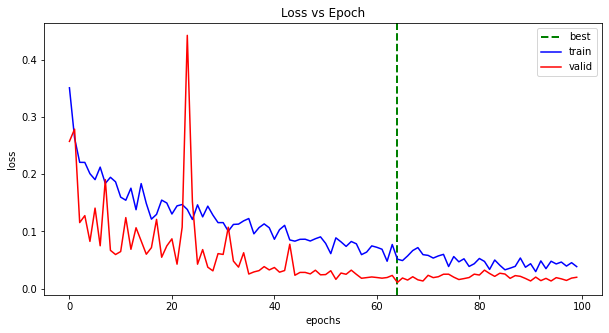

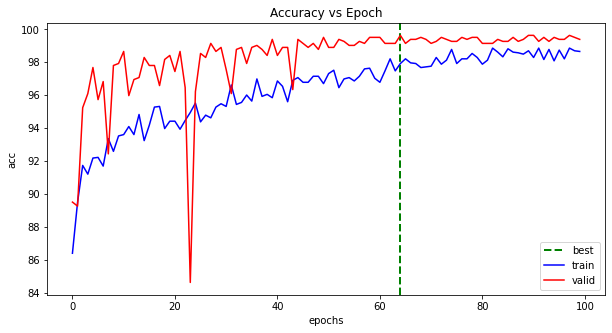

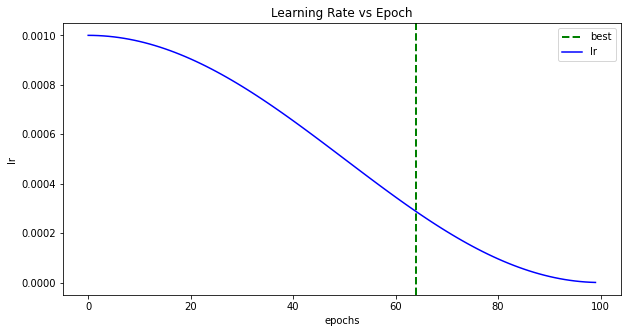

In [33]:
plt.figure(figsize=(10,5))
plt.axvline(epoch_[-1], 0, 1, c='g', ls='--', lw=2, label='best')
plt.plot(range(n_epochs), train_loss_, 'b', label='train')
plt.plot(range(n_epochs), valid_loss_, 'r', label='valid')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.axvline(epoch_[-1], 0, 1, c='g', ls='--', lw=2, label='best')
plt.plot(range(n_epochs), train_acc_, 'b', label='train')
plt.plot(range(n_epochs), valid_acc_, 'r', label='valid')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.axvline(epoch_[-1], 0, 1, c='g', ls='--', lw=2, label='best')
plt.plot(range(n_epochs), lr_, 'b', label='lr')
plt.xlabel('epochs')
plt.ylabel('lr')
plt.title('Learning Rate vs Epoch')
plt.legend()
plt.show()

In [34]:
plotTotal.append([net, train_acc_, train_loss_])

## Analysis

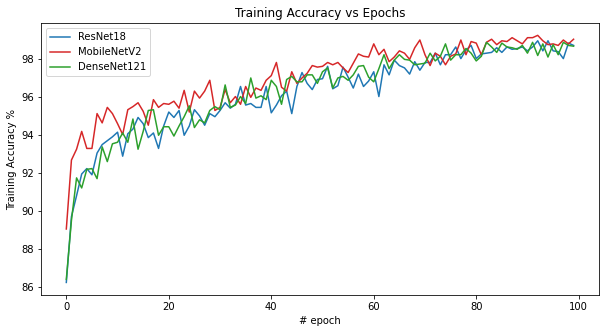

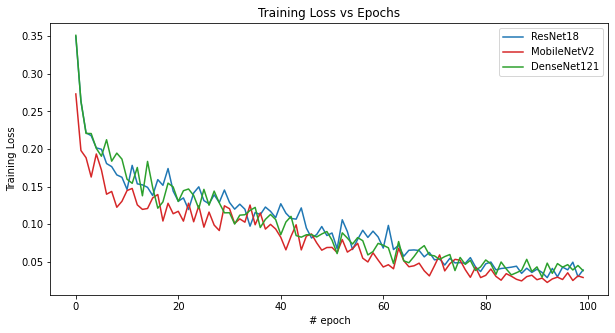

In [35]:
plt.figure(figsize=(10,5))
plt.plot(range(n_epochs), plotTotal[0][1], color='tab:blue', label='ResNet18')
plt.plot(range(n_epochs), plotTotal[1][1], color='tab:red', label='MobileNetV2')
plt.plot(range(n_epochs), plotTotal[2][1], color='tab:green', label='DenseNet121')
plt.xlabel('# epoch')
plt.ylabel('Training Accuracy %')
plt.title('Training Accuracy vs Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(range(n_epochs), plotTotal[0][2], color='tab:blue', label='ResNet18')
plt.plot(range(n_epochs), plotTotal[1][2], color='tab:red', label='MobileNetV2')
plt.plot(range(n_epochs), plotTotal[2][2], color='tab:green', label='DenseNet121')
plt.xlabel('# epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Epochs')
plt.legend()
plt.show()

# Evaluate

In [36]:
# the true (rows), predicted (columns)

def evaluate_test(model_path):
    net = torch.load(model_path, map_location=device)
    net.eval()
    y = list()
    y_hat = list()
    correct = 0
    total = 0
    with torch.no_grad():
        for image, label in testloader:
            image, label = image.to(device), label.to(device)
            y.append(label.item())
            total += label.size()[0]
            output = net(image)
            _, predicted = torch.max(output.data, 1)
            y_hat.append(predicted.item())
            correct += label.eq(predicted).cpu().sum()
    print(classification_report(y, y_hat))
#     print(ConfusionMatrixDisplay(confusion_matrix(y_true=y, y_pred=y_hat)))
    cm = ConfusionMatrixDisplay(confusion_matrix(y_true=y, y_pred=y_hat))
    cm.plot() 
    return correct/total*100

## ResNet18

---Evaluate best model---
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       433
           1       1.00      0.99      0.99       386

    accuracy                           1.00       819
   macro avg       1.00      0.99      1.00       819
weighted avg       1.00      1.00      1.00       819

Accuracy: 99.5116%
Time taken: 5.4322s


---Evaluate last model---
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       433
           1       0.99      0.99      0.99       386

    accuracy                           0.99       819
   macro avg       0.99      0.99      0.99       819
weighted avg       0.99      0.99      0.99       819

Accuracy: 99.3895%
Time taken: 5.0882s


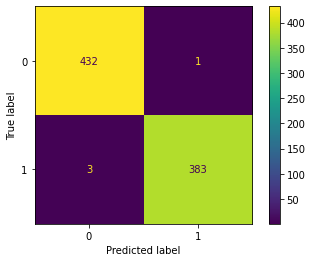

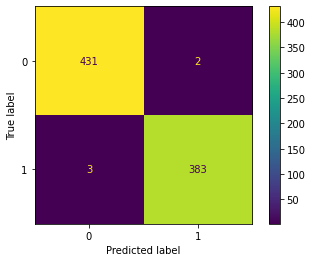

In [37]:
print('---Evaluate best model---')
start = time.time()
best_model_path = 'models/08012022_001139_resnet18_99.8779_epoch_64.pth'
print(f'Accuracy: {evaluate_test(best_model_path):.4f}%')
end = time.time()
print(f'Time taken: {(end-start):.4f}s')
print('\n')
print('---Evaluate last model---')
start = time.time()
last_model_path = 'models/08012022_002308_resnet18_98.70_99.51_last.pth'
print(f'Accuracy: {evaluate_test(last_model_path):.4f}%')
end = time.time()
print(f'Time taken: {(end-start):.4f}s')

## MobileNetV2

---Evaluate best model---
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       433
           1       0.99      0.98      0.99       386

    accuracy                           0.99       819
   macro avg       0.99      0.99      0.99       819
weighted avg       0.99      0.99      0.99       819

Accuracy: 98.6569%
Time taken: 8.3179s


---Evaluate last model---
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       433
           1       0.99      0.99      0.99       386

    accuracy                           0.99       819
   macro avg       0.99      0.99      0.99       819
weighted avg       0.99      0.99      0.99       819

Accuracy: 99.0232%
Time taken: 8.0158s


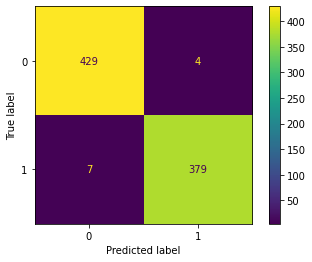

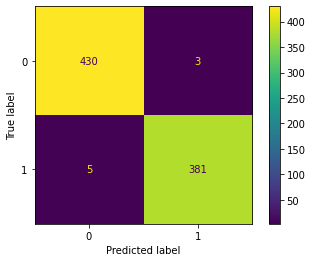

In [38]:
print('---Evaluate best model---')
start = time.time()
best_model_path = 'models/08012022_004422_mobilenetv2_99.8779_epoch_48.pth'
print(f'Accuracy: {evaluate_test(best_model_path):.4f}%')
end = time.time()
print(f'Time taken: {(end-start):.4f}s')
print('\n')
print('---Evaluate last model---')
start = time.time()
last_model_path = 'models/08012022_010637_mobilenetv2_99.02_99.88_last.pth'
print(f'Accuracy: {evaluate_test(last_model_path):.4f}%')
end = time.time()
print(f'Time taken: {(end-start):.4f}s')

## DenseNet121

---Evaluate best model---
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       433
           1       0.99      0.99      0.99       386

    accuracy                           0.99       819
   macro avg       0.99      0.99      0.99       819
weighted avg       0.99      0.99      0.99       819

Accuracy: 99.1453%
Time taken: 27.9243s


---Evaluate last model---
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       433
           1       1.00      0.97      0.99       386

    accuracy                           0.99       819
   macro avg       0.99      0.99      0.99       819
weighted avg       0.99      0.99      0.99       819

Accuracy: 98.6569%
Time taken: 27.3542s


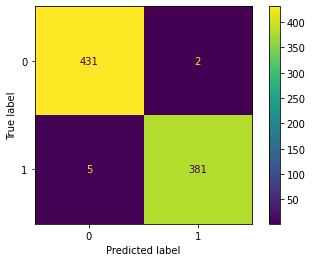

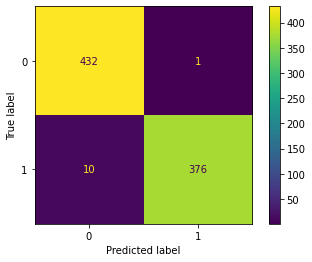

In [39]:
print('---Evaluate best model---')
start = time.time()
best_model_path = 'models/08012022_021509_densenet121_99.6337_epoch_64.pth'
print(f'Accuracy: {evaluate_test(best_model_path):.4f}%')
end = time.time()
print(f'Time taken: {(end-start):.4f}s')
print('\n')
print('---Evaluate last model---')
start = time.time()
last_model_path = 'models/08012022_025216_densenet121_98.66_99.39_last.pth'
print(f'Accuracy: {evaluate_test(last_model_path):.4f}%')
end = time.time()
print(f'Time taken: {(end-start):.4f}s')

In [40]:
net, param = zip(*sorted(list(zip([count_parameters(i[0]) for i in plotTotal], ['resnet18', 'mobilenetv2', 'densenet121']))))
print(net)
print(param)

(2226434, 6955906, 11177538)
('mobilenetv2', 'densenet121', 'resnet18')
